# Set up environment

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, matthews_corrcoef


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Loading the datasets into dataframes

In [2]:
df_fridayAF_DDos = pd.read_csv("./datasets/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv")
df_fridayAF_PortScan = pd.read_csv("./datasets/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv")
df_fridayMO = pd.read_csv("./datasets/Friday-WorkingHours-Morning.pcap_ISCX.csv")
df_monday = pd.read_csv("./datasets/Monday-WorkingHours.pcap_ISCX.csv")
df_thursdayAF_Infilteration = pd.read_csv("./datasets/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv")
df_thursdayMO_WebAttacks = pd.read_csv("./datasets/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv")
df_tuesday = pd.read_csv("./datasets/Tuesday-WorkingHours.pcap_ISCX.csv")
df_wednesday = pd.read_csv("./datasets/Wednesday-workingHours.pcap_ISCX.csv")

# Concatenating the dataframes to single dataframe

In [3]:
df_data = pd.concat([df_fridayAF_DDos,df_fridayAF_PortScan,df_fridayMO,df_monday,df_thursdayAF_Infilteration,df_thursdayMO_WebAttacks,df_tuesday,df_wednesday], axis=0,ignore_index=True)

In [4]:
df_data.head(5)

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3,2,0,12,0,6,6,6.0,0.0,0,0,0.0,0.0,4.000000e+06,666666.66670,3.0,0.0,3,3,3,3.0,0.0,3,3,0,0.0,0.0,0,0,0,0,0,0,40,0,666666.666700,0.000000,6,6,6.0,0.0,0.0,0,0,0,0,1,0,0,0,0,9.0,6.0,0.0,40,0,0,0,0,0,0,2,12,0,0,33,-1,1,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,1.100917e+05,18348.62385,109.0,0.0,109,109,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,20,20,9174.311927,9174.311927,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,1,9.0,6.0,6.0,20,0,0,0,0,0,0,1,6,1,6,29,256,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,2.307692e+05,38461.53846,52.0,0.0,52,52,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,20,20,19230.769230,19230.769230,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,1,9.0,6.0,6.0,20,0,0,0,0,0,0,1,6,1,6,29,256,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,46236,34,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,3.529412e+05,58823.52941,34.0,0.0,34,34,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,20,20,29411.764710,29411.764710,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,1,9.0,6.0,6.0,20,0,0,0,0,0,0,1,6,1,6,31,329,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,54863,3,2,0,12,0,6,6,6.0,0.0,0,0,0.0,0.0,4.000000e+06,666666.66670,3.0,0.0,3,3,3,3.0,0.0,3,3,0,0.0,0.0,0,0,0,0,0,0,40,0,666666.666700,0.000000,6,6,6.0,0.0,0.0,0,0,0,0,1,0,0,0,0,9.0,6.0,0.0,40,0,0,0,0,0,0,2,12,0,0,32,-1,1,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [5]:
df_data.describe()

/Users/Internship/Documents/GitHub/Capstone_Notebook/env/lib/python3.9/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/Internship/Documents/GitHub/Capstone_Notebook/env/lib/python3.9/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.829385e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2830743.0,2.830743e+06,2830743.0,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2830743.0,2830743.0,2830743.0,2830743.0,2830743.0,2830743.0,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06
mean,8.071483e+03,1.478566e+07,9.361160e+00,1.039377e+01,5.493024e+02,1.616264e+04,2.075999e+02,1.871366e+01,5.820194e+01,6.891013e+01,8.708495e+02,4.104958e+01,3.059493e+02,3.353257e+02,inf,inf,1.298449e+06,2.919271e+06,9.182475e+06,1.623796e+05,1.448296e+07,2.610193e+06,3.266957e+06,9.042939e+06,1.021893e+06,9.893830e+06,1.805784e+06,1.485973e+06,4.684692e+06,9.672614e+05,4.644646e-02,0.0,1.112782e-04,0.0,-2.599739e+04,-2.273275e+03,6.386535e+04,6.995192e+03,1.643450e+01,9.504024e+02,1.719444e+02,2.949756e+02,4.861548e+05,3.537976e-02,4.644646e-02,2.423392e-04,2.980705e-01,3.158443e-01,9.482316e-02,1.112782e-04,2.433990e-04,6.835004e-01,1.919837e+02,5.820194e+01,3.059493e+02,-2.599739e+04,0.0,0.0,0.0,0.0,0.0,0.0,9.361160e+00,5.492919e+02,1.039377e+01,1.616230e+04,6.989837e+03,1.989433e+03,5.418218e+00,-2.741688e+03,8.155132e+04,4.113412e+04,1.531825e+05,5.829582e+04,8.316037e+06,5.038439e+05,8.695752e+06,7.920031e+06
std,1.828363e+04,3.365374e+07,7.496728e+02,9.973883e+02,9.993589e+03,2.263088e+06,7.171848e+02,6.033935e+01,1.860912e+02,2.811871e+02,1.946367e+03,6.886260e+01,6.052568e+02,8.396932e+02,NaN,NaN,4.507944e+06,8.045870e+06,2.445954e+07,2.950282e+06,3.357581e+07,9.525722e+06,9.639055e+06,2.452916e+07,8.591436e+06,2.873661e+07,8.887197e+06,6.278469e+06,1.716095e+07,8.308983e+06,2.104500e-01,0.0,1.054826e-02,0.0,2.105286e+07,1.452209e+06,2.475371e+05,3.815170e+04,2.523772e+01,2.028229e+03,3.054915e+02,6.318001e+02,1.647490e+06,1.847378e-01,2.104500e-01,1.556536e-02,4.574107e-01,4.648513e-01,2.929706e-01,1.054826e-02,1.559935e-02,6.804920e-01,3.318603e+02,1.860912e+02,6.052568e+02,2.105286e+07,0.0,0.0,0.0,0.0,0.0,0.0,7.496728e+02,9.980070e+03,9.973883e+02,2.26305

#### we can notice from the above results that we have an outliers in the columns of Flow Bytes/s since the min has negative values

# Data Preprocessing

#### Find columns with zero variance; columns where all values are the same


In [6]:
zero_variance_cols = [col for col in df_data.columns if df_data[col].nunique() == 1]

# Display the columns with zero variance
if zero_variance_cols:
    print(f"Columns with zero variance: {zero_variance_cols}")
else:
    print("No columns with zero variance found.")

Columns with zero variance: [' Bwd PSH Flags', ' Bwd URG Flags', 'Fwd Avg Bytes/Bulk', ' Fwd Avg Packets/Bulk', ' Fwd Avg Bulk Rate', ' Bwd Avg Bytes/Bulk', ' Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate']


##### Shape before removing zero variance columns

In [7]:
print('Shape before removing zero variance columns:', df_data.shape)

Shape before removing zero variance columns: (2830743, 79)


#### Handle columns with zero variance

In [8]:
if zero_variance_cols:
        df_data.drop(zero_variance_cols, axis=1, inplace=True)
        print(f'Dropped zero variance columns: {zero_variance_cols}')

Dropped zero variance columns: [' Bwd PSH Flags', ' Bwd URG Flags', 'Fwd Avg Bytes/Bulk', ' Fwd Avg Packets/Bulk', ' Fwd Avg Bulk Rate', ' Bwd Avg Bytes/Bulk', ' Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate']


##### Shape after removing zero variance columns

In [9]:
print('Shape after removing zero variance columns:', df_data.shape)

Shape after removing zero variance columns: (2830743, 71)


#### Find  spaces from column names

In [10]:
df_data.keys()

Index([' Destination Port', ' Flow Duration', ' Total Fwd Packets',
       ' Total Backward Packets', 'Total Length of Fwd Packets',
       ' Total Length of Bwd Packets', ' Fwd Packet Length Max',
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean',
       ' Fwd Packet Length Std', 'Bwd Packet Length Max',
       ' Bwd Packet Length Min', ' Bwd Packet Length Mean',
       ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s',
       ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min',
       'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max',
       ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std',
       ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Fwd URG Flags',
       ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s',
       ' Bwd Packets/s', ' Min Packet Length', ' Max Packet Length',
       ' Packet Length Mean', ' Packet Length Std', ' Packet Length Variance',
       'FIN Flag Count', ' SYN Flag Count', 

##### Handle spaces from column names

In [11]:
print("Check for NaN values in Label column:", df_data[' Label'].isna().sum())


Check for NaN values in Label column: 0


In [12]:
df_data.columns = df_data.columns.str.strip()

#### Columns after removing spaces

In [13]:
df_data.keys()

Index(['Destination Port', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Total Length of Fwd Packets',
       'Total Length of Bwd Packets', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Fwd URG Flags',
       'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s',
       'Bwd Packets/s', 'Min Packet Length', 'Max Packet Length',
       'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance',
       'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count',

#### Identify Rows with NaN, inf, or -inf Values
##### The row listed here contain  NaN across the columns displayed.

In [14]:
# Select only numeric columns
numeric_cols = df_data.select_dtypes(include=[np.number])

# Check for inf and -inf values in the numeric columns
inf_values = np.isinf(numeric_cols).sum()

# Display the count of inf and -inf values in each numeric column
print("Count of inf and -inf values in each numeric column:")
print(inf_values)

Count of inf and -inf values in each numeric column:
Destination Port                  0
Flow Duration                     0
Total Fwd Packets                 0
Total Backward Packets            0
Total Length of Fwd Packets       0
Total Length of Bwd Packets       0
Fwd Packet Length Max             0
Fwd Packet Length Min             0
Fwd Packet Length Mean            0
Fwd Packet Length Std             0
Bwd Packet Length Max             0
Bwd Packet Length Min             0
Bwd Packet Length Mean            0
Bwd Packet Length Std             0
Flow Bytes/s                   1509
Flow Packets/s                 2867
Flow IAT Mean                     0
Flow IAT Std                      0
Flow IAT Max                      0
Flow IAT Min                      0
Fwd IAT Total                     0
Fwd IAT Mean                      0
Fwd IAT Std                       0
Fwd IAT Max                       0
Fwd IAT Min                       0
Bwd IAT Total                     0
Bwd IAT Mea

## Replace inf and -inf with Nan

In [15]:
df_data.replace([np.inf, -np.inf], np.nan, inplace=True)

In [16]:
df_data.isna().sum()

Destination Port                  0
Flow Duration                     0
Total Fwd Packets                 0
Total Backward Packets            0
Total Length of Fwd Packets       0
Total Length of Bwd Packets       0
Fwd Packet Length Max             0
Fwd Packet Length Min             0
Fwd Packet Length Mean            0
Fwd Packet Length Std             0
Bwd Packet Length Max             0
Bwd Packet Length Min             0
Bwd Packet Length Mean            0
Bwd Packet Length Std             0
Flow Bytes/s                   2867
Flow Packets/s                 2867
Flow IAT Mean                     0
Flow IAT Std                      0
Flow IAT Max                      0
Flow IAT Min                      0
Fwd IAT Total                     0
Fwd IAT Mean                      0
Fwd IAT Std                       0
Fwd IAT Max                       0
Fwd IAT Min                       0
Bwd IAT Total                     0
Bwd IAT Mean                      0
Bwd IAT Std                 

In [17]:
# Check for empty strings or negative values in Flow Bytes/s
sub_df = df_data[df_data['Flow Bytes/s'].isna() | (df_data['Flow Bytes/s'] == '') | (df_data['Flow Bytes/s'] < 0)]
sub_df['Label'].value_counts()

Label
BENIGN         1862
DoS Hulk        949
PortScan        126
Bot              10
FTP-Patator       3
DDoS              2
Name: count, dtype: int64

In [18]:
print("Check for NaN values in Label column:", df_data['Label'].isna().sum())


Check for NaN values in Label column: 0


In [19]:
df_data['Label'].value_counts()

Label
BENIGN                        2273097
DoS Hulk                       231073
PortScan                       158930
DDoS                           128027
DoS GoldenEye                   10293
FTP-Patator                      7938
SSH-Patator                      5897
DoS slowloris                    5796
DoS Slowhttptest                 5499
Bot                              1966
Web Attack � Brute Force         1507
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64

In [20]:
print(df_data.isna().sum())

Destination Port                  0
Flow Duration                     0
Total Fwd Packets                 0
Total Backward Packets            0
Total Length of Fwd Packets       0
Total Length of Bwd Packets       0
Fwd Packet Length Max             0
Fwd Packet Length Min             0
Fwd Packet Length Mean            0
Fwd Packet Length Std             0
Bwd Packet Length Max             0
Bwd Packet Length Min             0
Bwd Packet Length Mean            0
Bwd Packet Length Std             0
Flow Bytes/s                   2867
Flow Packets/s                 2867
Flow IAT Mean                     0
Flow IAT Std                      0
Flow IAT Max                      0
Flow IAT Min                      0
Fwd IAT Total                     0
Fwd IAT Mean                      0
Fwd IAT Std                       0
Fwd IAT Max                       0
Fwd IAT Min                       0
Bwd IAT Total                     0
Bwd IAT Mean                      0
Bwd IAT Std                 

### Options to handle missing values

##### Drop rows with missing values

In [21]:
df_data.dropna(inplace=True)

In [22]:
df_data.isna().sum()

Destination Port               0
Flow Duration                  0
Total Fwd Packets              0
Total Backward Packets         0
Total Length of Fwd Packets    0
Total Length of Bwd Packets    0
Fwd Packet Length Max          0
Fwd Packet Length Min          0
Fwd Packet Length Mean         0
Fwd Packet Length Std          0
Bwd Packet Length Max          0
Bwd Packet Length Min          0
Bwd Packet Length Mean         0
Bwd Packet Length Std          0
Flow Bytes/s                   0
Flow Packets/s                 0
Flow IAT Mean                  0
Flow IAT Std                   0
Flow IAT Max                   0
Flow IAT Min                   0
Fwd IAT Total                  0
Fwd IAT Mean                   0
Fwd IAT Std                    0
Fwd IAT Max                    0
Fwd IAT Min                    0
Bwd IAT Total                  0
Bwd IAT Mean                   0
Bwd IAT Std                    0
Bwd IAT Max                    0
Bwd IAT Min                    0
Fwd PSH Fl

In [23]:
print("Check for NaN values in Label column:", df_data['Label'].isna().sum())


Check for NaN values in Label column: 0


##### Identify duplicate rows

In [24]:
duplicate_rows = df_data[df_data.duplicated()]

if not duplicate_rows.empty:
    print("Duplicate rows:")
    print(duplicate_rows.shape)
else:
    print("No duplicate rows found.")

Duplicate rows:
(307078, 71)


##### Identify columns with identical values

In [25]:
column_pairs = []
num_columns = len(df_data.columns)

for i in range(num_columns):
    for j in range(i + 1, num_columns):
        if df_data.iloc[:, i].equals(df_data.iloc[:, j]): 
            column_pairs.append((df_data.columns[i], df_data.columns[j]))

In [26]:
print("Shape before removing identical columns:", df_data.shape)

Shape before removing identical columns: (2827876, 71)


##### Print the column pairs with identical values

In [27]:
if column_pairs:
    print("Columns with identical values:")
    for pair in column_pairs:
        print(f"{pair[0]} and {pair[1]} have identical values.")
    
    # Step 3: Drop one column from each pair
    columns_to_drop = [pair[1] for pair in column_pairs]
    df_data.drop(columns=columns_to_drop, axis=1, inplace=True)
    print(f"Dropped columns: {columns_to_drop}")
else:
    print("No columns with identical values found.")

print("Shape after removing identical columns:", df_data.shape)

Columns with identical values:
Total Fwd Packets and Subflow Fwd Packets have identical values.
Total Backward Packets and Subflow Bwd Packets have identical values.
Fwd PSH Flags and SYN Flag Count have identical values.
Fwd URG Flags and CWE Flag Count have identical values.
Fwd Header Length and Fwd Header Length.1 have identical values.
Dropped columns: ['Subflow Fwd Packets', 'Subflow Bwd Packets', 'SYN Flag Count', 'CWE Flag Count', 'Fwd Header Length.1']
Shape after removing identical columns: (2827876, 66)


### Check for non-numeric columns

In [28]:
non_numeric_columns = df_data.select_dtypes(include=['object']).columns
print("Non-numeric columns:", non_numeric_columns)

Non-numeric columns: Index(['Label'], dtype='object')


In [29]:
print("Check for NaN values in Label column:", df_data['Label'].isna().sum())


Check for NaN values in Label column: 0


In [30]:
df_data['Label'].unique()

array(['BENIGN', 'DDoS', 'PortScan', 'Bot', 'Infiltration',
       'Web Attack � Brute Force', 'Web Attack � XSS',
       'Web Attack � Sql Injection', 'FTP-Patator', 'SSH-Patator',
       'DoS slowloris', 'DoS Slowhttptest', 'DoS Hulk', 'DoS GoldenEye',
       'Heartbleed'], dtype=object)

In [31]:
print(df_data['Label'].unique())  # Before mapping

['BENIGN' 'DDoS' 'PortScan' 'Bot' 'Infiltration'
 'Web Attack � Brute Force' 'Web Attack � XSS'
 'Web Attack � Sql Injection' 'FTP-Patator' 'SSH-Patator' 'DoS slowloris'
 'DoS Slowhttptest' 'DoS Hulk' 'DoS GoldenEye' 'Heartbleed']


In [32]:
df_data['Label'] = df_data['Label'].map({
    'BENIGN': 0,
    'DDoS': 1,
    'PortScan': 1,
    'Bot': 1,
    'Infiltration': 1,
    'Web Attack @ Brute Force': 1,  # Add missing labels
    'Web Attack @ XSS': 1,
    'Brute Force': 1,
    'Web Attack @ SQL Injection': 1,
    'FTP-Patator': 1,
    'SSH-Patator': 1,
    'DoS slowloris': 1,
    'DoS Slowhttptest': 1,
    'DoS Hulk': 1,
    'DoS GoldenEye': 1,
    'Heartbleed': 1
})

In [33]:
df_data = df_data.dropna(subset=['Label'])



In [34]:
print(df_data['Label'].isna().sum())  # This should return 0 after the correct mapping
print(df_data['Label'].unique())  # Should show only 0 and 1

0
[0. 1.]


In [35]:
# Extract rows with NaN in the 'Label' column
unmapped_labels = df_data[df_data['Label'].isna()]

# Print the unique labels causing NaN values
print(unmapped_labels['Label'].unique())  # This will show you the missing labels


[]


/var/folders/83/s9_py62d54b6v0352dkn68_80000gp/T/ipykernel_29232/251548084.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(['Benign', 'Attack'])


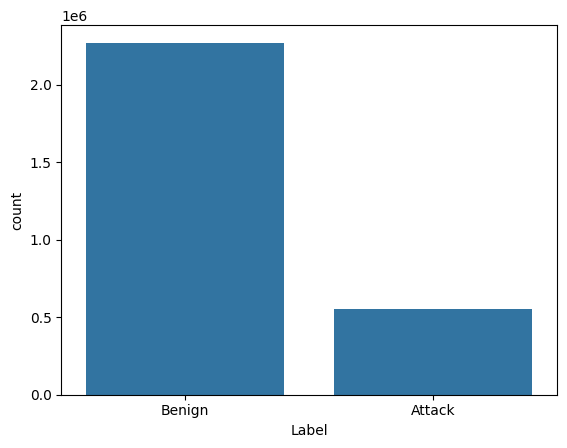

Label
0.0    2271320
1.0     554376
Name: count, dtype: int64


In [36]:
# Plot the countplot for the 'Label' column
sns.countplot(x='Label', data=df_data)

# Change the x-tick labels to 'Benign' for 0 and 'Attack' for 1 (only in the plot)
plt.gca().set_xticklabels(['Benign', 'Attack'])

# Show the plot
plt.show()

# Print the original value counts (which retains 0 and 1)
print(df_data['Label'].value_counts())


In [37]:
print("Check for NaN values in Label column:", df_data['Label'].isna().sum())


Check for NaN values in Label column: 0


In [38]:
print(f"Number of duplicate rows: {df_data.duplicated().sum()}")
df_data = df_data.drop_duplicates()
print(f"Number of duplicate rows after removal: {df_data.duplicated().sum()}")

Number of duplicate rows: 307041
Number of duplicate rows after removal: 0


In [39]:
print("Check for NaN values in Label column:", df_data['Label'].isna().sum())


Check for NaN values in Label column: 0


In [40]:
df_data['Label'].value_counts()

Label
0.0    2095057
1.0     423598
Name: count, dtype: int64

In [41]:
print("Check for NaN values in Label column:", df_data['Label'].isna().sum())


Check for NaN values in Label column: 0


## Create a heatmap to visualize missing values

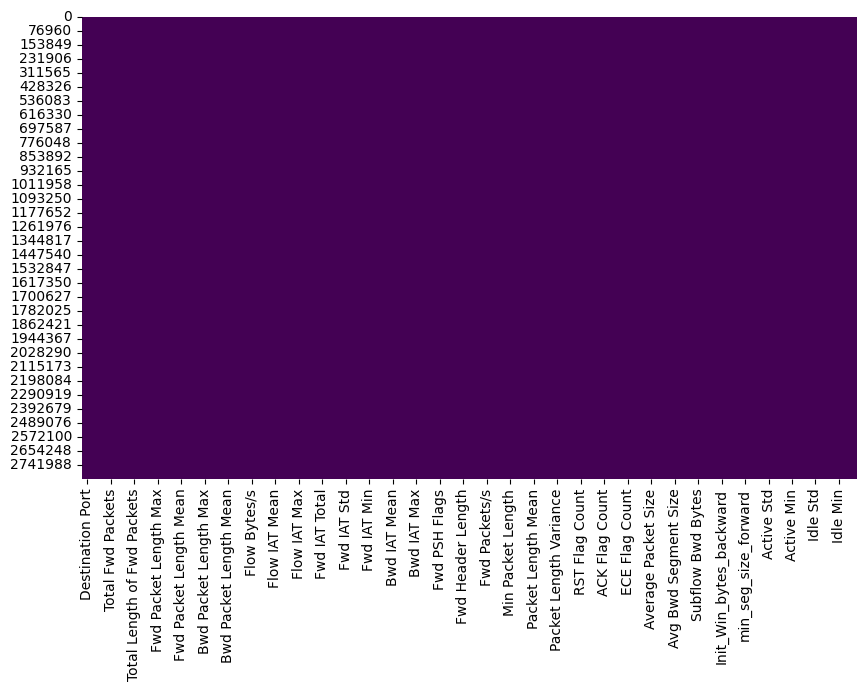

In [42]:
plt.figure(figsize=(10,6))
sns.heatmap(df_data.isnull(), cbar=False, cmap='viridis')
plt.show()

In [43]:
print("Check for NaN values in Label column:", df_data['Label'].isna().sum())


Check for NaN values in Label column: 0


## print categorical columns unique values < 10
## append to categorical_columns = []
##  numerical columns are the ones that are not in categorical columns



In [44]:
categorical_columns = []

for c in df_data.columns:
    # Check if the column is categorical (dtype of object or category) or numerical with less than 10 unique values
    if df_data[c].nunique() < 10:
        # Print unique values of columns with < 10 unique values
        print(f"Column '{c}' has unique values: {df_data[c].unique()}")
        categorical_columns.append(c)

# If you want to display the list of categorical columns with unique values < 10
print("Columns with unique values < 10:")
print(categorical_columns)

Column 'Fwd PSH Flags' has unique values: [0 1]
Column 'Fwd URG Flags' has unique values: [0 1]
Column 'FIN Flag Count' has unique values: [0 1]
Column 'RST Flag Count' has unique values: [0 1]
Column 'PSH Flag Count' has unique values: [0 1]
Column 'ACK Flag Count' has unique values: [1 0]
Column 'URG Flag Count' has unique values: [0 1]
Column 'ECE Flag Count' has unique values: [0 1]
Column 'Label' has unique values: [0. 1.]
Columns with unique values < 10:
['Fwd PSH Flags', 'Fwd URG Flags', 'FIN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count', 'ECE Flag Count', 'Label']


In [45]:
numerical_columns = [col for col in df_data.columns if col not in categorical_columns]
categorical_columns.remove('Label')

## Exploratory Data Analysis (EDA) 

## Class Distribution
### Check the distribution of the target variable (Label) to identify whether the data is balanced or imbalanced.

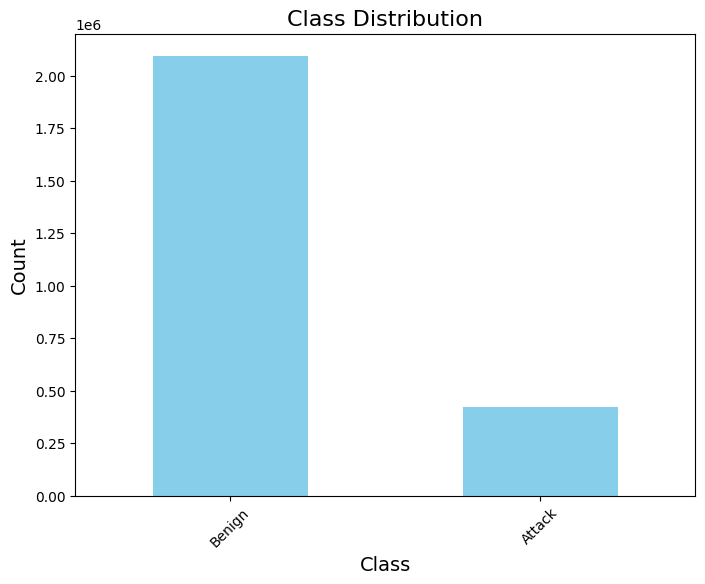

In [46]:
class_counts = df_data['Label'].value_counts()

plt.figure(figsize=(8, 6))
class_counts.plot(kind='bar', color='skyblue')

plt.title('Class Distribution', fontsize=16)
plt.xlabel('Class', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.gca().set_xticklabels(['Benign', 'Attack'])


plt.xticks(rotation=45)
plt.show()

LabelEncoder: Converts the categorical Label column (e.g., 'Benign', 'Malicious', etc.) into numeric values so that mutual_info_classif can handle it.
select_dtypes(include=[float, int]): Ensures that only numeric features are passed to mutual_info_classif to avoid mixing types (strings and numbers).
Mutual Information Plot: After calculating the mutual information, the features are sorted by importance and displayed in a bar plot.

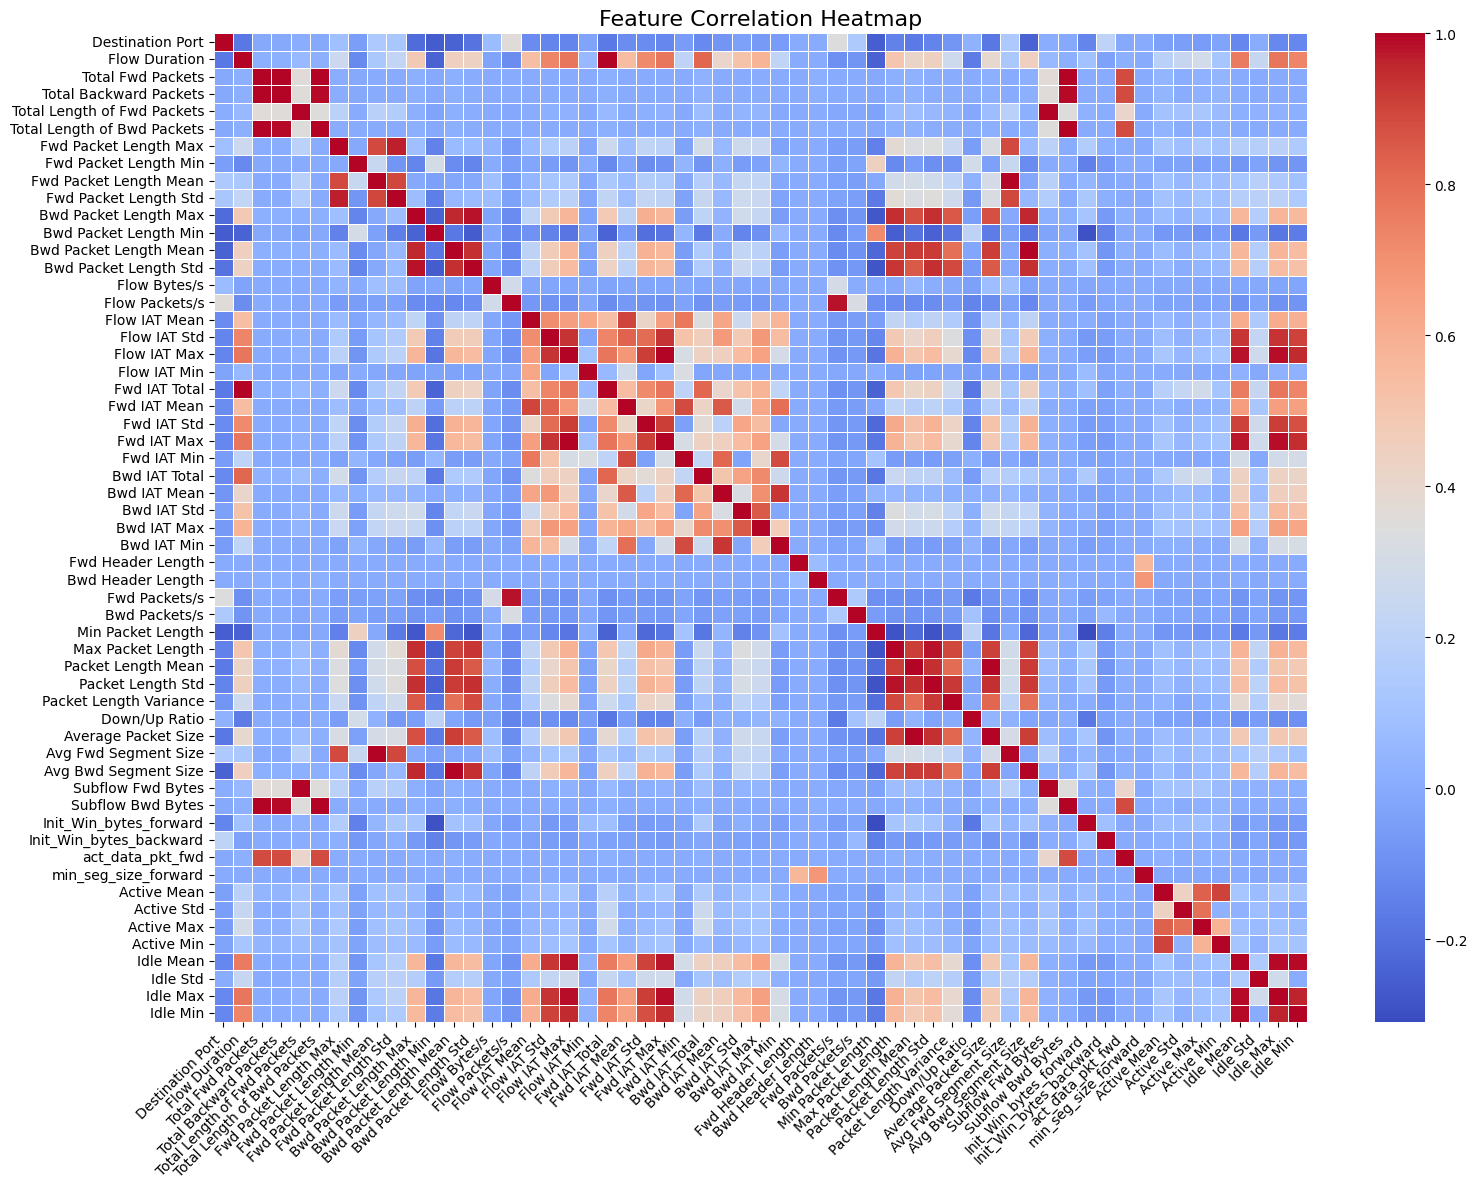

In [47]:
# Select only numeric columns for the correlation matrix
numeric_columns = df_data[numerical_columns]

# Calculate the correlation matrix
corr_matrix = numeric_columns.corr()

# Plotting the heatmap with adjustments
plt.figure(figsize=(16, 12))  # Increase figure size to make it more readable
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=0.5)

# Rotate x and y axis labels for better readability
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)

# Add a title to the heatmap
plt.title('Feature Correlation Heatmap', fontsize=16)
plt.tight_layout()  # Adjust layout to ensure labels fit well
plt.show()


## Since there are too many features, I focused on the most correlated features by selecting a subset

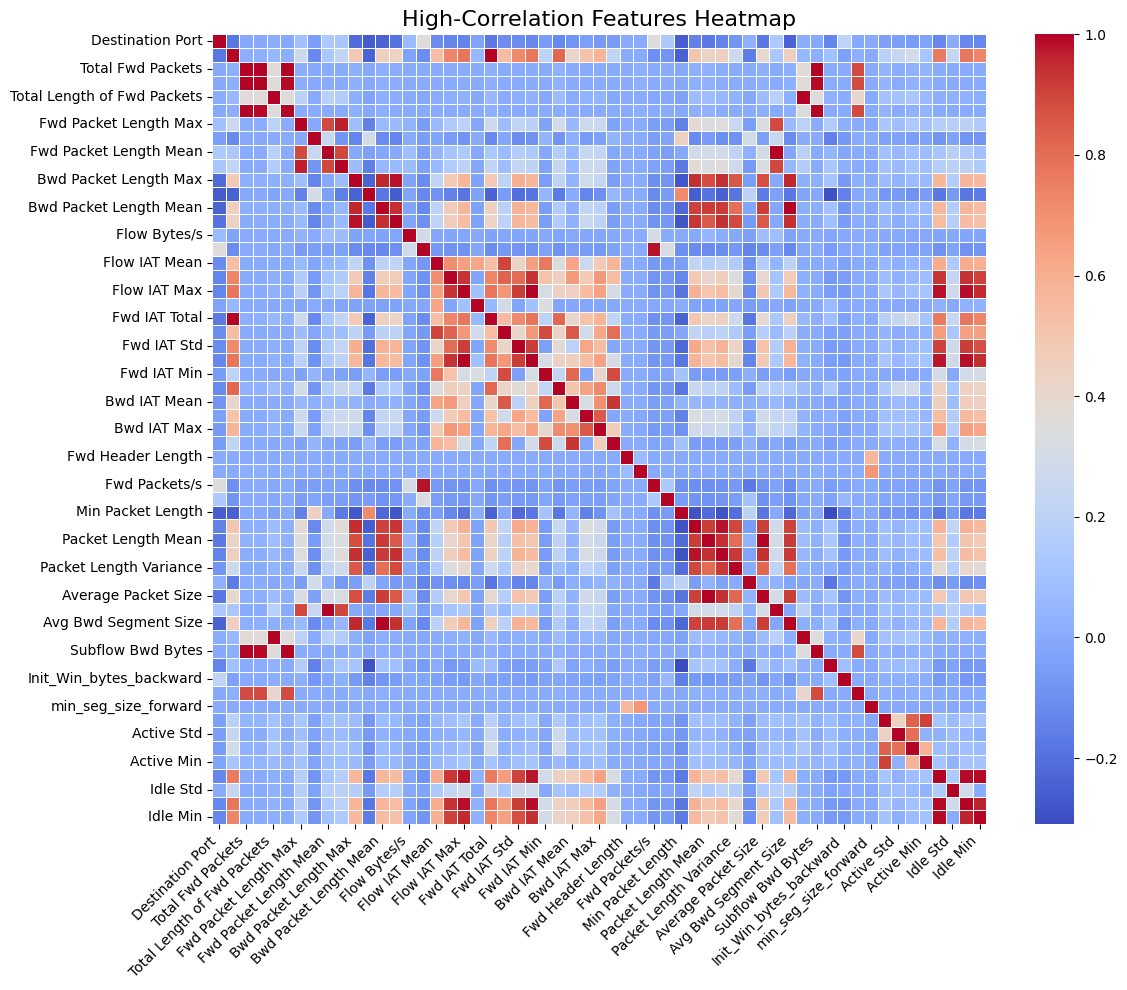

In [49]:
# Select top correlated features (optional)
corr_threshold = 0.5  # Example: Use a threshold to filter features
high_corr_features = corr_matrix.columns[(corr_matrix.abs() > corr_threshold).any()].tolist()

# Plot only the high-correlation features
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix.loc[high_corr_features, high_corr_features], annot=False, cmap='coolwarm', linewidths=0.5)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.title('High-Correlation Features Heatmap', fontsize=16)
plt.tight_layout()
plt.show()


## Distribution of Features
### Plot the distribution of key numerical features to understand their behavior in both normal and attack classes.

In [50]:
feature_list = df_data.columns.tolist()
print(feature_list)

['Destination Port', 'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Total Length of Fwd Packets', 'Total Length of Bwd Packets', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Fwd URG Flags', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s', 'Min Packet Length', 'Max Packet Length', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count', 'ECE Flag Count', 'Down/Up Ratio', 'Average Packet Size', 'Avg Fwd Segment Size', 'Av

Reduce Bins in Histogram:
By default, sns.histplot may use many bins, which can slow down the plot generation. You can reduce the number of bins to speed up the process.

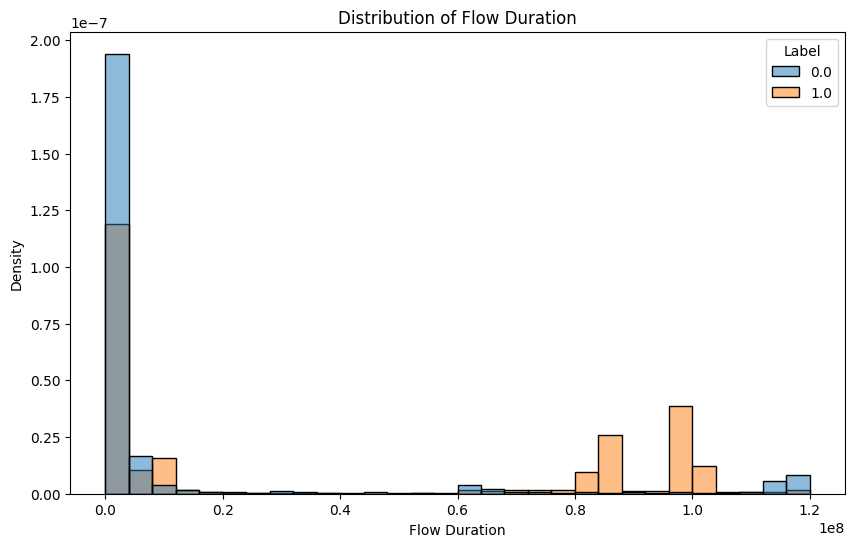

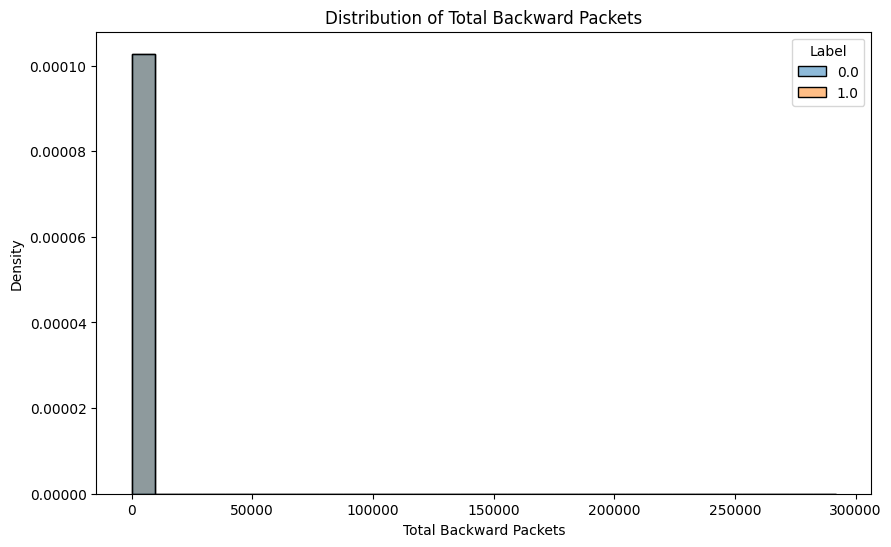

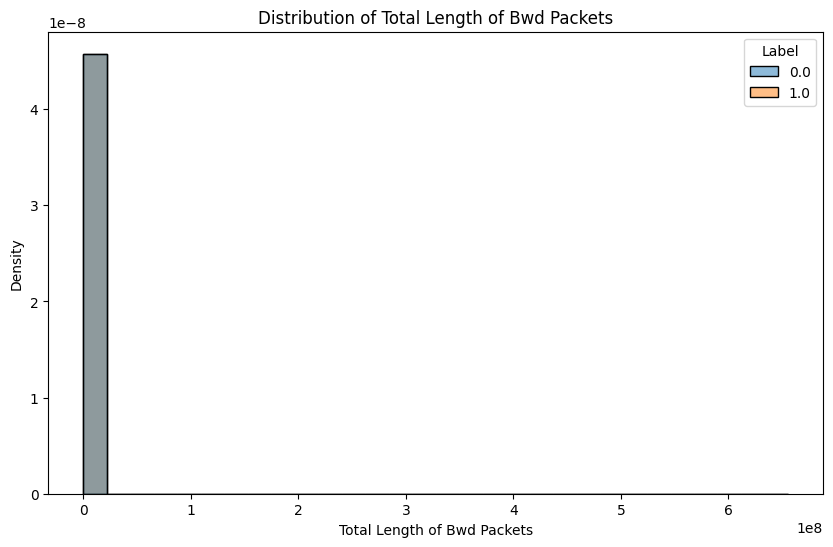

In [51]:
features_to_plot = ['Flow Duration', 'Total Backward Packets', 'Total Length of Bwd Packets']

for feature in features_to_plot:
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df_data, x=feature, hue='Label', kde=False, bins=30, stat="density", common_norm=False)  # Reduced bins
    plt.title(f'Distribution of {feature}')
    plt.show()


## Box Plot to Check Outliers
### Box plots help identify outliers within the dataset for each feature.

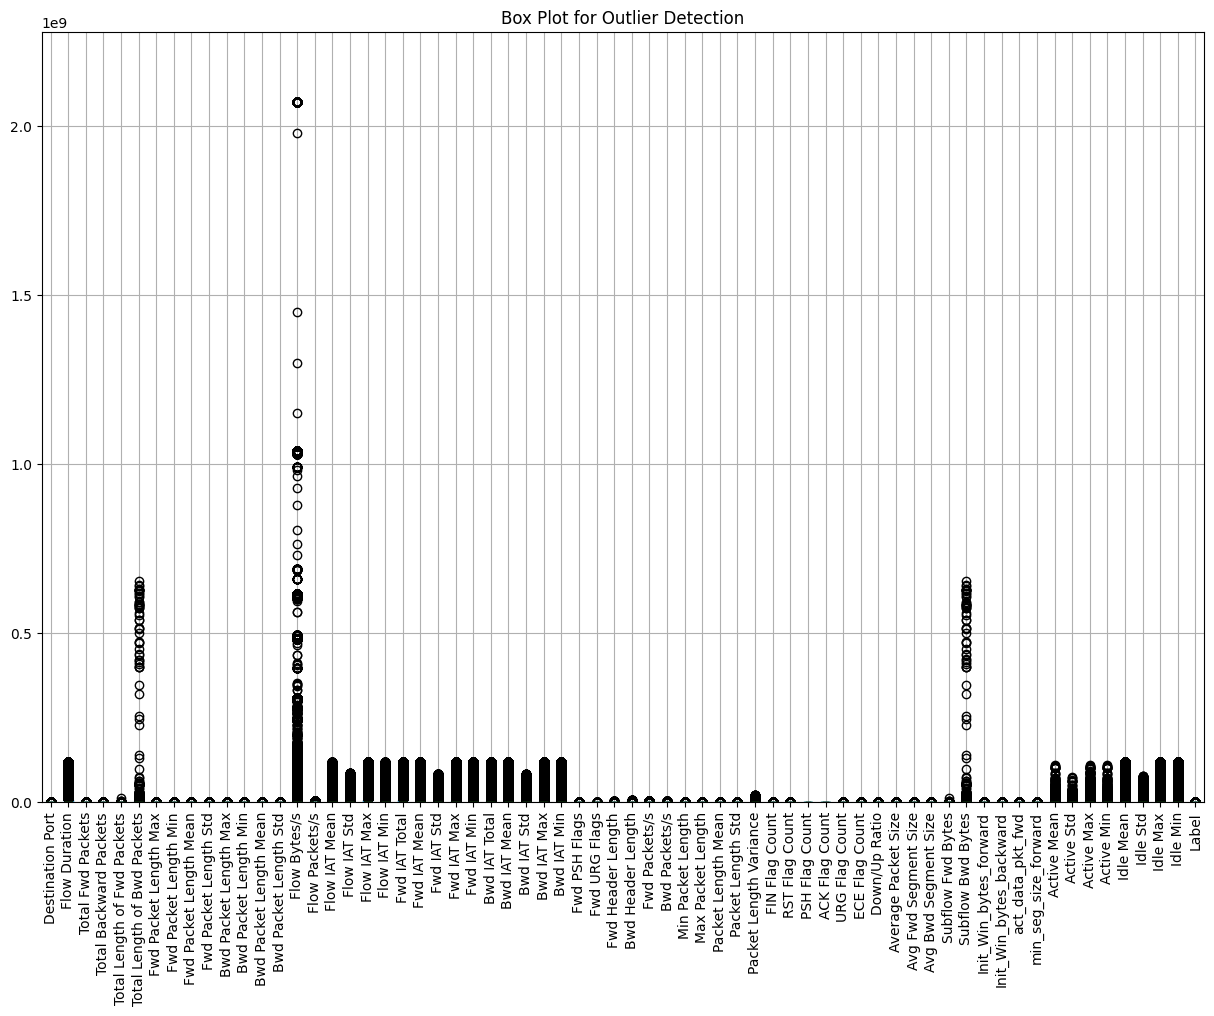

In [52]:
# Select numerical columns
numerical_columns = df_data.select_dtypes(include=[np.number]).columns

# Plot box plots for each numerical column
plt.figure(figsize=(15, 10))
df_data[numerical_columns].boxplot(rot=90)
plt.title("Box Plot for Outlier Detection")
plt.ylim(0, max(df_data[numerical_columns].max())*1.1)  # Adjust the upper limit as needed
plt.show()


### Focus on the "Flow Bytes/s" column only

(0.0, 2278100000.0)

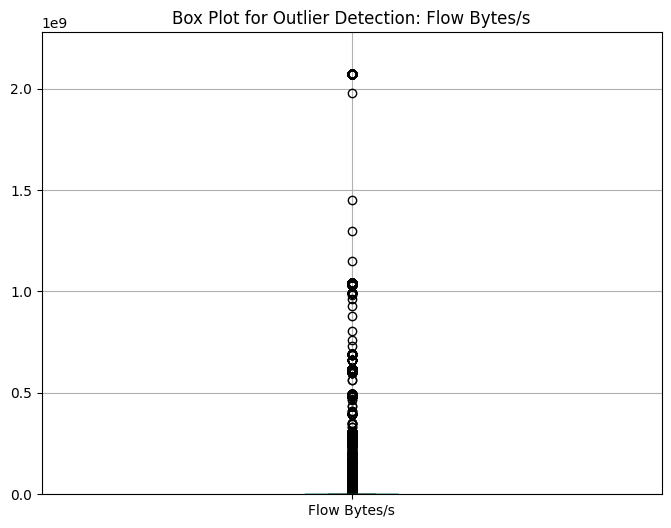

In [53]:
column_of_interest = 'Flow Bytes/s'

# Plot box plot for the selected column
plt.figure(figsize=(8, 6))
df_data[[column_of_interest]].boxplot()
plt.title(f"Box Plot for Outlier Detection: {column_of_interest}")
plt.ylim(0, df_data[column_of_interest].max() * 1.1) 


## calculate the importance for every feature

In [ ]:
# # Box plot for selected features
# for feature in subset_features:
#     plt.figure(figsize=(10, 6))
#     sns.boxplot(data=df_data, x='Label', y=feature)
#     plt.title(f'Boxplot of {feature} by Class')
#     plt.show()

## Feature Engineering

## Feature Importance

In [55]:
print("Check for NaN values in Label column:", df_data['Label'].isna().sum())


Check for NaN values in Label column: 0


# ======================+=============+

In [56]:
# Drop rows with missing values
X = df_data.drop('Label',axis=1)

# Make sure to drop corresponding rows in y
y = df_data['Label']

# Split the dataset into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [57]:
# Initialize the RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Train the classifier
rf.fit(X_train, y_train)

# # Calculate feature importances
feature_importances = rf.feature_importances_

KeyboardInterrupt: 

## calculate the importance for every feature

In [ ]:
# # Assuming 'Label' is your target variable and the rest are features
X = df_data.drop('Label', axis=1)  # Features
y = df_data['Label']  # Target


# # Split the dataset into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Calculate mutual information between numerical features and the target
importances = mutual_info_classif(X_train, y_train)

# Convert to a pandas DataFrame for easier visualization
mi_series = pd.Series(importances, index=X.columns)

# Sort the features by importance
mi_series = mi_series.sort_values(ascending=False)

# Plot the mutual information values
plt.figure(figsize=(10, 6))
mi_series.plot(kind='bar', color='skyblue')
plt.title('Mutual Information Between Features and Label')
plt.xlabel('Features')
plt.ylabel('Mutual Information')
plt.show()

## calculate the sum of importance scores

In [ ]:
# Sort the feature importances along with the feature names (numerical_columns)
f_list = sorted(zip(map(lambda x: round(x, 4), importances), X_train.columns), reverse=True) ## 

# Initialize variables
Sum = 0
fs = []

# Calculate the sum of feature importances and store features
for i in range(len(f_list)):
    Sum += f_list[i][0]  # Summing up the importance scores
    fs.append(f_list[i][1])  # Append the feature name to the list

# Optional: Print or return the feature importances and the sum
print("Sum of feature importances:", Sum)

## We select the important feature until the accumulated importance reaches 90%

In [135]:
f_list2 = sorted(zip(map(lambda x: round(x, 4), importances/Sum), X_train.columns), reverse=True)
Sum2 = 0
fs = []

for i in range(0, len(f_list2)):
    Sum2 = Sum2 + f_list2[i][0]
    fs.append(f_list2[i][1])
    
    if Sum2 >= 0.9:
        break

In [ ]:
print(len(fs))
# fs = 

### Splitting of the data

In [137]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

### Apply Z-Score Normalization

In [ ]:
print(X_train.dtypes)  # This will display the data types of all columns

# Ensure 'numeric_columns' only contains valid numeric columns
numeric_columns = X_train.select_dtypes(include=['float64', 'int64']).columns.tolist()
print(numeric_columns)

# ============================================

In [ ]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

# # List of numeric columns (confirmed from the data)
# numeric_columns = ['Destination Port', 'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 
#                    'Total Length of Fwd Packets', 'Total Length of Bwd Packets', 'Fwd Packet Length Max', 
#                    'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 
#                    'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 
#                    'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 
#                    'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 
#                    'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 
#                    'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Fwd URG Flags', 
#                    'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s', 
#                    'Min Packet Length', 'Max Packet Length', 'Packet Length Mean', 'Packet Length Std', 
#                    'Packet Length Variance', 'FIN Flag Count', 'RST Flag Count', 'PSH Flag Count', 
#                    'ACK Flag Count', 'URG Flag Count', 'ECE Flag Count', 'Down/Up Ratio', 'Average Packet Size', 
#                    'Avg Fwd Segment Size', 'Avg Bwd Segment Size', 'Subflow Fwd Bytes', 'Subflow Bwd Bytes', 
#                    'Init_Win_bytes_forward', 'Init_Win_bytes_backward', 'act_data_pkt_fwd', 
#                    'min_seg_size_forward', 'Active Mean', 'Active Std', 'Active Max', 'Active Min', 
#                    'Idle Mean', 'Idle Std', 'Idle Max', 'Idle Min']

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler only on the training data and transform it
X_train_scaled = scaler.fit_transform(X_train[numerical_columns])

# Transform the test data using the same scaler
X_test_scaled = scaler.transform(X_test[numeric_columns])

# Convert the scaled data back into DataFrames for ease of use
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=numeric_columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=numeric_columns)

# If you have categorical columns to concatenate, you can do it like this:
# Concatenate the scaled numerical features with any categorical features (if applicable)
# X_train_categorical and X_test_categorical should be your categorical feature DataFrames
# Assuming you've processed/encoded the categorical columns

X_train_final = pd.concat([X_train_scaled_df, X_train.reset_index(drop=True)], axis=1)
X_test_final = pd.concat([X_test_scaled_df, X_test.reset_index(drop=True)], axis=1)

# Print the shape of the final datasets to verify the concatenation
print("X_train_final shape:", X_train_final.shape)
print("X_test_final shape:", X_test_final.shape)

In [ ]:
# # concatenate X_train_scaled with X_train categorical
# # X_test_scaled with  with X_test

# # Concatenate scaled and categorical features for training data
# X_train_final = np.concatenate([X_train_scaled, X_train], axis=1)

# # Concatenate scaled and categorical features for test data
# X_test_final = np.concatenate([X_test_scaled, X_test], axis=1)

# # Print the shapes to verify
# print("X_train_final shape:", X_train_final.shape)
# print("X_test_final shape:", X_test_final.shape)

# Training Models
#### Model that could be use for binary classification

## Random Forest Classifier

### Training

In [ ]:
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train_final, y_train)

### Testing

In [ ]:
y_pred = rfc.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
mcc = matthews_corrcoef(y_test, y_pred)

print("Accuracy:", accuracy * 100)
print('Recall:', recall * 100)
print('Precision:', precision * 100)
print('F1 Score:', f1 * 100)
print('MCC:', mcc * 100)

### Confusion matrix

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', 
            xticklabels=['BENIGN', 'DDos'], yticklabels=['BENIGN', 'DDos'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

### Hyperparameter Tuning

In [ ]:
# Define parameter grid
param_dist = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=100,
    scoring='f1_weighted',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit random search to the data
random_search.fit(X_train_scaled, y_train)

# Print best parameters
print("Best Hyperparameters:", random_search.best_params_)

## Evaluation Steps

In [ ]:
# Evaluate the best model on the test set
best_rf = random_search.best_estimator_
y_pred = best_rf.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print("Accuracy:", accuracy * 100)
print("F1 Score:", f1 * 100)

In [ ]:
# Confusion matrix visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()